# Read the PDF

In [1]:
# libraries for text cleaning
%pip install nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords as sw
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# library to read the PDF
%pip install pdfplumber
import pdfplumber

# convert date string to datetime format
from datetime import datetime

import pandas as pd

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trentyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/trentyoung/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/trentyoung/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Note: you may need to restart the kernel to use updated packages.


In [2]:
# We should use this code
# this is the text extracted from the first 3 pages extracted from the
def raw_data_extraction(input_pdf):
    # take the pdf as an input and return the whole pdf as text
    raw_input=""
    with pdfplumber.open(input_pdf) as pdf:
        for page in pdf.pages:
            raw_input+=(page.extract_text() or "") + "\n"
    return raw_input

def article_extraction(raw_input):
    article=""
    details=""
    article_idx=0
    article_dict={}
    details_dict={}
    article_status=False # mark the start of the article
    details_status=False
    for row in raw_input.lower().split('\n'):
        if row=='full text':
            article_status=True
            article_idx+=1
            continue
        if article_status:
            if row=='details':
                article_status=False
                details_status=True
                article_dict[article_idx] = article
                article=""
                continue
            article+=row+" "
        if details_status:
            if row=='links':
                details_status=False
                details_dict[article_idx]=details
                details=""
                continue
            details+=row+'\n'
    return article_dict, details_dict

def clean_article(article):
    lemmatizer=WordNetLemmatizer()
    desc = re.sub(r'\([^)]*\)', '', article)
    sent_desc =sent_tokenize(desc)
    sww=set(sw.words())
    abstraction = []
    for sent in sent_desc:
        # normalise U.S., US, USA, U.S.A., etc. all to "america" (for classification)
        sent = re.sub(r"\b(?:u\.?\s*s\.?|usa|u\.?\s*s\.?\s*a\.?)\b", "america", sent, flags=re.IGNORECASE)
        # normalise to lowercase and only letters and numbers
        tokens = re.sub(r"[^a-z0-9]+", " ", sent.lower())
        words = word_tokenize(tokens)
        remaining_words = [word for word in words if word not in sww]
        if remaining_words:
            lemmatised_words=[]
            for word in remaining_words:
                lemmatised_word=lemmatizer.lemmatize(word)
                lemmatised_words.append(lemmatised_word)
            abstraction.append(lemmatised_words)
    final_doc=""
    for sent in abstraction[:-1]:
        for word in sent:
            final_doc+=word+" "
    return final_doc # remove the name of the writer

def clean_detail(detail):
    year=None
    date=None
    article_id=""
    for row in detail.split('\n'):
        if row.split(":")[0]=="proquest document id" or row.split(":")[0]=="proquestdocument id" or row.split(":")[0]=="proquestdocumentid" or row.split(":")[0]=="proquest documentid":
            article_id=row.split(":")[1].strip().split(" ")
            if len(article_id)>1:
                new_id=""
                for part in article_id:
                    new_id+=part
                article_id=[new_id]
            continue
        #if row.split(":")[0]=="publication year":
            #year = str(row.split(":")[1].strip())
            #print(year)
        if row.split(":")[0]=="publication date":
            raw_date=row.split(":")[1].split(",")[0].strip().split(" ")
            raw_year=row.split(":")[1].split(",")[1].strip().split(" ")
            raw_date1=""
            raw_date2=""
            for value in raw_date: # add date
                raw_date1+=value
            for value in raw_year: # add year
                raw_date1+=value
            if len(raw_date1)==8:
                raw_date2+=raw_date1[:3]+" "+raw_date1[3]+" "+raw_date1[4:]
            if len(raw_date1)==9:
                raw_date2+=raw_date1[:3]+" "+raw_date1[3:5]+" "+raw_date1[5:]
            #full_raw_date= raw_date2 + " "+ year
            format_date= "%b %d %Y"           
            date = datetime.strptime(raw_date2, format_date)
    return (date.date() if date else None), article_id
    

#raw_input1=raw_data_extraction('3pages.pdf')
#article1, details1=article_extraction(raw_input1)
#doc1=clean_article(article1[1])
#date1, article_id1=clean_detail(details1[1])

In [3]:
demo_date1=' au g 9 2025'
demo_date2=" sep 1 0 2025"
date1=""
date2=""
new_date1=""
new_date2=""
for value in demo_date1.strip().split(" "):
    date1+=value
for value in demo_date2.strip().split(" "):
    date2+=value
if len(date1)==8:
    new_date1=" "+date1[:3]+" "+date1[3]+" "+date1[4:]
    print(new_date1)
if len(date2)==9:
    new_date2=" "+date2[:3]+" "+date2[3:5]+" "+date2[5:]
    print(new_date2)


 aug 9 2025
 sep 10 2025


# To find the unique words and count for the 222 articles

1-3 grams

In [4]:
raw_input222 = raw_data_extraction('ProQuestDocuments-2025-08-16_1_fiscalpolicy_last12.pdf')
article222_dict, details222_dict = article_extraction(raw_input222)

#for key in article222_dict.keys():
 #   cleaned_article222 = clean_article(article222_dict[key])
 #   print(cleaned_article222)

In [5]:
from nltk.util import ngrams
from collections import Counter

# cleaned tokens 
all_tokens = []
for key, article in article222_dict.items():
    cleaned_article = clean_article(article)   
    tokens = cleaned_article.split()
    all_tokens.extend(tokens)

# remove token that are only numbers
def is_word(token):
    # keep only tokens with letters (ignore pure numbers)
    return re.match(r'^[A-Za-z]+$', token)

filtered_tokens = [tok for tok in all_tokens if is_word(tok)]

# 1/2/3 grams
ngram_counts = Counter()
for n in [1, 2, 3]:
    ngrams_list = [" ".join(ng) for ng in ngrams(filtered_tokens, n)]
    ngram_counts.update(ngrams_list)

# top n phrases (500)
top_phrases = ngram_counts.most_common(500)

# results
print("Number of unique phrases (1–3 grams):", len(ngram_counts))
print("Top 500 phrases:\n")
for phrase, count in top_phrases:
    print(f"{phrase}: {count}")

 
# Convert the list of tuples into a df
top_phrases_df = pd.DataFrame(top_phrases, columns=["phrase", "count"])

# esxport to csv
top_phrases_df.to_csv("top_phrases.csv", index=False)

Number of unique phrases (1–3 grams): 172903
Top 500 phrases:

tax: 1199
trump: 1099
america: 941
year: 918
cut: 698
republican: 556
house: 503
president: 480
tariff: 454
spending: 451
bill: 434
policy: 415
government: 414
budget: 371
china: 356
rate: 352
company: 352
fiscal: 337
tax cut: 335
economic: 321
federal: 317
economy: 310
state: 309
billion: 298
deficit: 287
market: 284
plan: 280
price: 279
growth: 273
increase: 268
administration: 264
million: 261
senate: 259
trillion: 251
country: 235
cost: 233
trade: 233
month: 229
higher: 227
debt: 223
time: 218
inflation: 218
make: 216
term: 209
investor: 204
program: 201
bank: 201
official: 196
day: 196
change: 195
week: 194
income: 193
dollar: 193
security: 193
money: 189
economist: 184
including: 184
democrat: 180
business: 177
vote: 176
american: 175
congress: 169
interest: 168
party: 168
treasury: 164
work: 163
recent: 162
back: 162
high: 160
pay: 160
biden: 159
investment: 157
white: 154
medicaid: 154
office: 152
law: 152
committee

# Create the set of fiscal policy related words

In [6]:
# the set of recurring words in these articles related to fiscal policy
'''
fiscal_terms=['tariffs', 'tax cuts', 'budget deficits', 'presidents', 'fiscal policy', 'political campaigns', 'federal budget', 'economic growth', 'interest rates',
                'tax increases', 'gross domestic' , 'income taxes', 'international relations-us', 'profits', 'stock exchanges', 'supply chains', 'tax refunds','product-gdp', 'tax rates', 'economists', 'government spending', 'investments', 'voters', 'inflation', 'legislators', 'taxes',
                'federal reserve monetory policy', 'investors', 'presidential elections', 'congressional committees', 'borrowing', 'central banks', 'immigration policy', 
                'international trade', 'economic conditions', 'legislation', 'american dollar', 'social security', 'dow jones averages', 'pandemics', 'treasuries', 'costs',
                'funding', 'manufacturing', 'political leadership', 'clean technology', 'national debt', 'national security', 'stocks', 'exports', 'immigrants',
                'leadership', 'medicare', 'political parties', 'prime ministers', 'scandals', 'tax credits', 'trade policy', 'border security', 'consumer price index',
                'defense spending', 'economic impact', 'economic policy', 'employees', 'federal legislation', 'households', 'immigration', 'international relations', 'low income groups',
                'prices', 'social networks', 'tax legislation', 'trade disputes', 'budgets', 'consumers', 'corporate profits', 'currency', 'deportation', 
                'infrastructure', 'international economic relations', 'nominations', 'nvidia corp', 'polls & surveys', 'provisions', 'recessions', 'securities markets',
                'trade relations', 'bond markets', 'cities', 'consumptions', 'cost control', 'decision making', 'deficit financing', 'economic crisis', 'economic development enforcement', 
                'factories', 'federal funding', 'global economy', 'government bonds']
'''


"\nfiscal_terms=['tariffs', 'tax cuts', 'budget deficits', 'presidents', 'fiscal policy', 'political campaigns', 'federal budget', 'economic growth', 'interest rates',\n                'tax increases', 'gross domestic' , 'income taxes', 'international relations-us', 'profits', 'stock exchanges', 'supply chains', 'tax refunds','product-gdp', 'tax rates', 'economists', 'government spending', 'investments', 'voters', 'inflation', 'legislators', 'taxes',\n                'federal reserve monetory policy', 'investors', 'presidential elections', 'congressional committees', 'borrowing', 'central banks', 'immigration policy', \n                'international trade', 'economic conditions', 'legislation', 'american dollar', 'social security', 'dow jones averages', 'pandemics', 'treasuries', 'costs',\n                'funding', 'manufacturing', 'political leadership', 'clean technology', 'national debt', 'national security', 'stocks', 'exports', 'immigrants',\n                'leadership', 'medic

In [7]:
# group all terms into groups - The categories needs to be double checked
terms_categories1={'tax': ['tax cuts','tax increases', 'tax rates', 'tax credits', 'taxes', 'tax legislation', 'income taxes', 'tax refunds', 'corporate profits', 'profits'],
                'tariffs_trade': ['tariffs', 'trade policy', 'trade disputes','international trade','trade relations', 'exports','supply chains', 'border security', 'international relations-us', 'international relations', 'immigration policy', 'immigrants', 'immigration', 'deportation'],
                'budget_debt': ['budget deficits', 'federal budget', 'budgets', 'deficit financing', 'national debt', 'treasuries', 'borrowing', 'federal funding', 'funding', 'cost control', 'costs', 'investments', 'provisions'],
                'spending_social_program': ['government spending', 'defense spending', 'infrastructure', 'social security', 'medicare', 'federal legislation', 'households', 'low income groups', 'national security', 'pandemics', 'manufacturing'],
                'monetary_financial_policy': ['government bonds', 'bond markets', 'federal reserve monetory policy', 'central banks', 'stocks', 'stock exchanges', 'dow jones averages','american dollar', 'currency', 'securities markets', 'fiscal policy', 'interest rates', 'inflation', 'consumer price index', 'prices', 'recessions', 'enforcement'],
                'economy': ['economists', 'economic growth', 'economic conditions', 'economic policy', 'economic impact', 'international economic relations', 'global economy', 'economic crisis', 'economic development', 'gross domestic product-gdp', 'economic development enforcement'],
                'other_context': ['presidents', 'investors', 'political campaigns', 'political leadership', 'political parties', 'legislation','congressional committees','prime ministers','scandals','nominations', 'clean technology', 'cities', 'voters', 'legislators', 'leadership', 'consumers', 'social networks', 'presidential elections', 'nvidia corp', 'polls & surveys', 'consumptions', 'decision making','employees', 'factories'],
                'america': ['america', 'american', "alabama", "alaska", "arizona", "arkansas", "california", "colorado", 
                "connecticut", "delaware", "florida", "georgia", "hawaii", "idaho",
                "illinois", "indiana", "iowa", "kansas", "kentucky", "louisiana",
                "maine", "maryland", "massachusetts", "michigan", "minnesota",
                "mississippi", "missouri", "montana", "nebraska", "nevada",
                "new hampshire", "new jersey", "new mexico", "new york",
                "north carolina", "north dakota", "ohio", "oklahoma", "oregon",
                "pennsylvania", "rhode island", "south carolina", "south dakota",
                "tennessee", "texas", "utah", "vermont", "virginia", "washington",
                "west virginia", "wisconsin", "wyoming"]
                }

In [12]:
terms_categories = {
    # Core fiscal categories
    'tax': ['tax cuts','tax increases','tax rates','taxes','tax legislation','income taxes'],
    
    'budget_debt': ['budget deficits','federal budget','deficit financing','national debt',
                    'borrowing','federal funding','government debt'],
    
    'spending_social_programs': ['defense spending','social security','medicare','stimulus',
                                'federal spending'],

    'fiscal_policy': ['fiscal policy','fiscal stimulus','fiscal reform'],

    'tariffs_trade': ['tariffs','trade policy','trade disputes','international trade',
                    'trade relations','exports','supply chains','border security',
                    'immigration policy','immigration','deportation',],

    # America filter
    'america': ['america','american',
        "alabama","alaska","arizona","arkansas","california","colorado",
        "connecticut","delaware","florida","georgia","hawaii","idaho",
        "illinois","indiana","iowa","kansas","kentucky","louisiana",
        "maine","maryland","massachusetts","michigan","minnesota",
        "mississippi","missouri","montana","nebraska","nevada",
        "new hampshire","new jersey","new mexico","new york",
        "north carolina","north dakota","ohio","oklahoma","oregon",
        "pennsylvania","rhode island","south carolina","south dakota",
        "tennessee","texas","utah","vermont","virginia","washington",
        "west virginia","wisconsin","wyoming"]
}


# Match the terms and categories with the documents

In [14]:
# this for the list of fiscal_terms (not categories)
# lemmatizing the set of fiscal words so they match the lemmatized articles
#def lemmatize_string(string, lemmatizer):
    #return " ".join(lemmatizer.lemmatize(w) for w in string.split())

#lemmatizer = WordNetLemmatizer()
#fiscal_terms_lemmatized = [lemmatize_string(term, lemmatizer) for term in fiscal_terms]

In [10]:
# match the fiscal terms to the document
#def count_matching_words(terms_list, document):
    #terms_count={}
    #for term in terms_list:
        #term_count=document.count(term)
        #if term_count>0:
            #terms_count[term]=term_count
    ##return terms_count

#count_matching_words(fiscal_terms_lemmatized,doc1)


NameError: name 'count_matching_words' is not defined

In [15]:
# this for the categoires of fiscal_terms (not list)
# lemmatizing the set of fiscal words so they match the lemmatized articles

def lemmatize_string(string, lemmatizer):
    return " ".join(lemmatizer.lemmatize(w) for w in string.split())
    
def lemmatize_categories(categories, lemmatizer):
    lemmatized = {}
    for key, terms in categories.items():
        lemmatized[key] = [lemmatize_string(term, lemmatizer) for term in terms]
    return lemmatized

lemmatizer = WordNetLemmatizer()
terms_categories_lemmatized = lemmatize_categories(terms_categories, lemmatizer) # keep this

In [18]:
# how many rules do want want to match

# match the fiscal term groups to the document
def count_matching_category(terms_categories, document):
    # this function will count number of terms in fiscal policy categories and classified whether a new is fical_policy related or not
    terms_list=[word for category in terms_categories.values() for word in category]
    terms_count={}
    is_fiscal=False
    for term in terms_list:
        term_count=document.count(term)
        if term_count>0:
            for key in terms_categories.keys():
                if term in terms_categories[key]:
                    terms_count[key]=terms_count.get(key,0)+term_count
    if len(terms_count.keys())>=2 and 'america' in terms_count.keys(): # >= 2 means 2 categories but one is 'america'
        is_fiscal=True
    return terms_count, is_fiscal # return the boolean values for terms_count.keys()>=3

#terms_count, is_fiscal=count_matching_category(terms_categories_lemmatized,doc1)
#terms_count, is_fiscal

# Make the dataframe to store the data

In [19]:
def full_pipeline(input_pdf):
    raw_input=raw_data_extraction(input_pdf)
    article_dict, details_dict = article_extraction(raw_input)
    column_names =['article_id', 'date', 'is_fiscal_article', 'has_tariff']
    fiscal_articles_df=pd.DataFrame(columns=column_names)
    
    for key in article_dict.keys():
        cleaned_article=clean_article(article_dict[key])
        date, article_id=clean_detail(details_dict[key])
        #print(article_id)
        #number_matching_words = count_matching_words(terms_categories_lemmatized, cleaned_article) # do we need this?
        number_matching_terms, is_fiscal=count_matching_category(terms_categories_lemmatized,cleaned_article)
        # tariff flag code
        has_tariff = any(term in cleaned_article for term in terms_categories_lemmatized["tariffs_trade"])
        #print(fiscal_articles_df['article_id'].values)


        if article_id[0] not in fiscal_articles_df['article_id'].values: # checked for duplicated articles
            fiscal_articles_df.loc[key]=[article_id[0], date, is_fiscal, has_tariff]
    return fiscal_articles_df   
    

In [ ]:
full_pipeline("ProQuestDocuments-2025-08-16_1_fiscalpolicy_last12.pdf").to_csv("fiscal_articles.csv")

# Fiscal Index Calculation

In [ ]:
fiscal_article_df=pd.read_csv("fiscal_articles.csv")

In [ ]:
# checking how many fiscal articles - this should be 222 of 222 articles
print(fiscal_article_df['is_fiscal_article'].sum())

219


In [ ]:
# checking how many tariff articles - 
print(fiscal_article_df['has_tariff'].sum())

154


In [ ]:
# sorted the data from oldest to latest
fiscal_article_df = fiscal_article_df.sort_values(by='date', ascending=True)

In [ ]:
fiscal_article_df

,Unnamed: 0,article_id,date,is_fiscal_article
221,222,3093027041,2024-08-15,True
220,221,3093378089,2024-08-16,True
219,220,3094633204,2024-08-20,True
218,219,3095348612,2024-08-22,True
217,218,3097659684,2024-08-28,True
...,...,...,...,...
4,5,3237867670,2025-08-09,True
3,4,3237878296,2025-08-09,True
2,3,3238849695,2025-08-13,True
1,2,3238853083,2025-08-13,True


In [ ]:
# count number of fiscal articles per day
fiscal_policy_index=fiscal_article_df[['date', 'is_fiscal_article']].groupby(by="date").sum().reset_index()
# total number of articles per day
fiscal_policy_index['total_articles'] = fiscal_article_df.groupby('date').size().values
# index score for each date = fiscal articles per day / total articles per 
fiscal_policy_index['rate'] = round(fiscal_policy_index['is_fiscal_article'] / fiscal_policy_index['total_articles'], 4)

In [ ]:
fiscal_policy_index#['date']

,date,is_fiscal_article,total_articles,rate
0,2024-08-15,1,1,1.0
1,2024-08-16,1,1,1.0
2,2024-08-20,1,1,1.0
3,2024-08-22,1,1,1.0
4,2024-08-28,1,1,1.0
...,...,...,...,...
150,2025-08-06,2,2,1.0
151,2025-08-08,1,1,1.0
152,2025-08-09,2,2,1.0
153,2025-08-13,2,2,1.0


In [ ]:
# rate of fiscle articles per day
# for now, it is assumed that the number of articles per day published by WSJ is 240 - number of articles per day by WSJ 
#fiscal_policy_index['rate']=round(fiscal_policy_index['is_fiscal_article']/240,4)

In [ ]:
# calculate the base mean
average_rate=fiscal_policy_index['rate'].mean()

In [ ]:
# calculate the fiscal policy index
fiscal_policy_index["fiscal_policy_index"]=round((fiscal_policy_index['rate']/average_rate)*100,4)

<Axes: xlabel='date'>

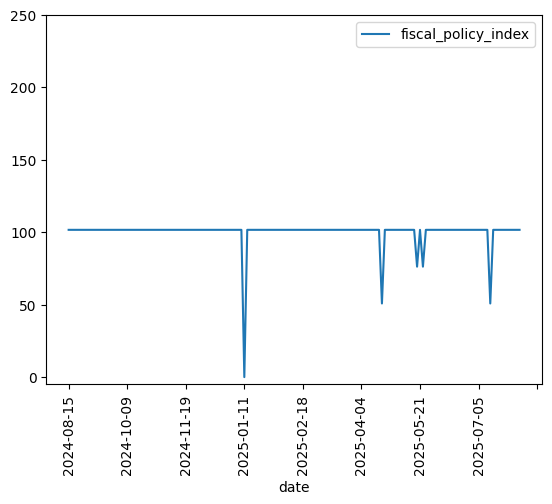

In [ ]:
fiscal_policy_index.plot(x='date', y='fiscal_policy_index', yticks=range(0,300,50), kind='line', rot=90)

In [ ]:
# checking fiscal policy data frame
fiscal_policy_index.head(50)

,date,is_fiscal_article,total_articles,rate,fiscal_policy_index
0,2024-08-15,1,1,1.0,101.6393
1,2024-08-16,1,1,1.0,101.6393
2,2024-08-20,1,1,1.0,101.6393
3,2024-08-22,1,1,1.0,101.6393
4,2024-08-28,1,1,1.0,101.6393
5,2024-09-03,1,1,1.0,101.6393
6,2024-09-06,1,1,1.0,101.6393
7,2024-09-10,1,1,1.0,101.6393
8,2024-09-13,1,1,1.0,101.6393
9,2024-09-14,1,1,1.0,101.6393


In [ ]:
# checking how many fiscal articles - this should be 222 of 222 articles
print(fiscal_policy_index['is_fiscal_article'].sum())

217


# This is a new changes

In [20]:
# using gglob to collect all of the PDF files in /fiscal_policy_index/data_articles
import glob

pdf_wsj = glob.glob("data_articles/*.pdf")
print("There are", len(pdf_wsj), "Wall Street Journal PDFs")

There are 34 Wall Street Journal PDFs


In [21]:
all_articles = []
for pdf in pdf_wsj:
    print(f"Processing {pdf} ...")
    df = full_pipeline(pdf)   
    all_articles.append(df)

# one df
wsj_df = pd.concat(all_articles, ignore_index=True)

Processing data_articles/ProQuestDocuments-2025-08-16_1_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_8_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_9_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_10_500.pdf ...
Processing data_articles/ProQuest Documents 23-24_8.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-3.pdf ...
Processing data_articles/ProQuest Documents 23-24_10.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_2_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-2.pdf ...
Processing data_articles/ProQuest Documents 23-24_9.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-6.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_3_500.pdf ...
Processing data_articles/ProQuestDocuments-2025-10-02-7.pdf ...
Processing data_articles/ProQuestDocuments-2025-08-16_11_500.pdf ...
Processing data_article

In [22]:
# move to code block above
# export to csv
wsj_df.to_csv("wsj_articles.csv", index=False)

# Fiscal News Index Calculation

In [23]:
import pandas as pd

# read in csv instead of using local variable assignment of wsj_df
wsj_df = pd.read_csv("wsj_articles.csv", parse_dates=["date"])

wsj_df.head(10)

,article_id,date,is_fiscal_article,has_tariff
0,3239236707,2025-08-14,True,False
1,3239232132,2025-08-14,False,False
2,3239232131,2025-08-14,False,False
3,3239232127,2025-08-14,False,False
4,3239232123,2025-08-14,True,True
5,3239232119,2025-08-14,True,True
6,3239232113,2025-08-14,True,True
7,3239232109,2025-08-14,False,False
8,3239232107,2025-08-14,True,True
9,3239232106,2025-08-14,True,True


In [ ]:
# sorted the data from oldest to latest
#wsj_df = wsj_df.sort_values(by='date', ascending=True)


# daily Fiscal Index Score

# count number of fiscal articles per day
#wsj_fpi=wsj_df[['date', 'is_fiscal_article']].groupby(by="date").sum().reset_index()
# total number of articles per day
#wsj_fpi['total_articles'] = wsj_df.groupby('date').size().values
# index score for each date = fiscal articles per day / total articles per 
#wsj_fpi['rate'] = round(wsj_fpi['is_fiscal_article'] / wsj_fpi['total_articles'], 4)
# mean to normalise the rate
#avg_rate = wsj_fpi['rate'].mean()
# normalise the fiscal policy index score
#wsj_fpi['fiscal_policy_index'] = round((wsj_fpi['rate'] / avg_rate) * 100, 4)


In [24]:
# Experimenting to plot fiscal score, fiscal score tariff included, fiscal score no tariff

# sort from oldest to latest
wsj_df = wsj_df.sort_values(by='date', ascending=True)

# ---- Daily Fiscal Index Scores ----
wsj_fpi = wsj_df.groupby("date").agg(
    total_articles=("article_id", "count"),
    fiscal_articles=("is_fiscal_article", "sum"),
    tariff_fiscal_articles=("has_tariff", "sum")   # tariff flagged articles
).reset_index()

# non-tariff fiscal articles = fiscal - tariff
wsj_fpi["non_tariff_fiscal_articles"] = (
    wsj_fpi["fiscal_articles"] - wsj_fpi["tariff_fiscal_articles"]
)

# rates
wsj_fpi["rate"] = wsj_fpi["fiscal_articles"] / wsj_fpi["total_articles"] # rate of fiscal articles
wsj_fpi["tariff_rate"] = wsj_fpi["tariff_fiscal_articles"] / wsj_fpi["total_articles"]
wsj_fpi["non_tariff_rate"] = wsj_fpi["non_tariff_fiscal_articles"] / wsj_fpi["total_articles"]

# normalize each (mean = 100)
wsj_fpi["fiscal_policy_index"] = wsj_fpi["rate"] / wsj_fpi["rate"].mean() * 100
wsj_fpi["tariff_fiscal_index"] = wsj_fpi["tariff_rate"] / wsj_fpi["tariff_rate"].mean() * 100
wsj_fpi["non_tariff_fiscal_index"] = wsj_fpi["non_tariff_rate"] / wsj_fpi["non_tariff_rate"].mean() * 100


In [25]:
# wsj_fpi df
wsj_fpi.head(5)

,date,total_articles,fiscal_articles,tariff_fiscal_articles,non_tariff_fiscal_articles,rate,tariff_rate,non_tariff_rate,fiscal_policy_index,tariff_fiscal_index,non_tariff_fiscal_index
0,2022-08-16,22,7,3,4,0.318182,0.136364,0.181818,97.381212,65.458179,153.541082
1,2022-08-17,24,8,4,4,0.333333,0.166667,0.166667,102.018413,80.004441,140.745991
2,2022-08-18,27,7,4,3,0.259259,0.148148,0.111111,79.347654,71.115059,93.830661
3,2022-08-19,16,3,2,1,0.187500,0.125000,0.062500,57.385357,60.003331,52.779747
4,2022-08-20,17,4,3,1,0.235294,0.176471,0.058824,72.012997,84.710584,49.675056


<Axes: >

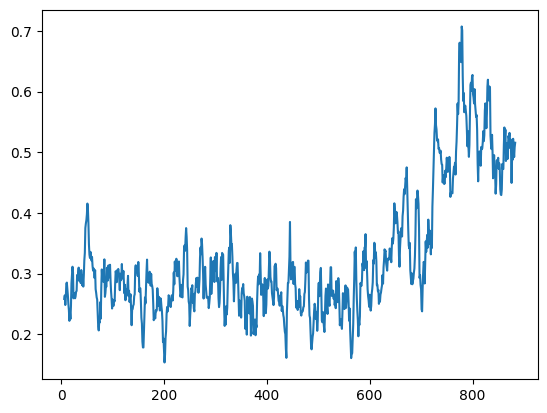

In [26]:
wsj_fpi['rate'].rolling(7).mean().plot()

In [27]:
print(wsj_fpi['fiscal_articles'].sum())
print(wsj_fpi['total_articles'].sum())
print(round((wsj_fpi['fiscal_articles'].sum() / wsj_fpi['total_articles'].sum()) * 100, 2),'%', 
      "of articles are fiscal articles")

5411
16647
32.5 % of articles are fiscal articles


<Axes: title={'center': 'Fiscal Policy Index Over Time'}, xlabel='date'>

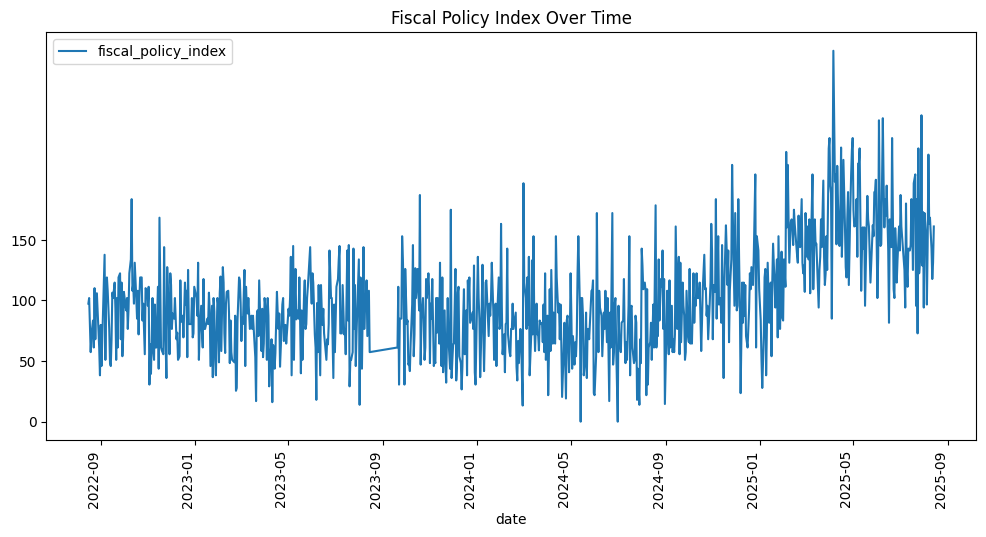

In [28]:
# plot the score over time
wsj_fpi.plot(x="date", y="fiscal_policy_index", kind="line", 
    figsize=(12,6), rot=90, yticks=range(0, 200, 50), 
    title="Fiscal Policy Index Over Time")

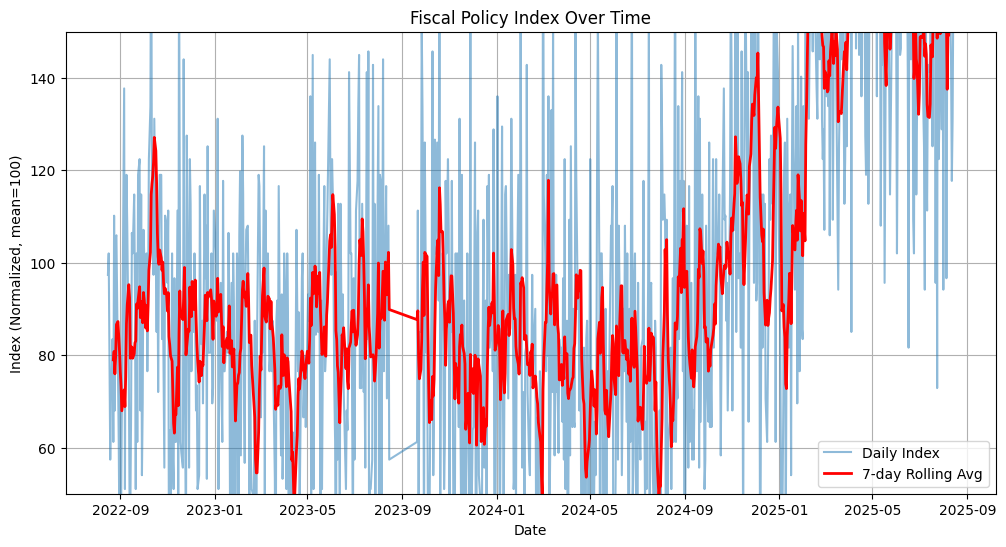

In [29]:
# with a 7 day rolling average (smoother)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(wsj_fpi["date"], wsj_fpi["fiscal_policy_index"], label="Daily Index", alpha=0.5)
plt.plot(wsj_fpi["date"], wsj_fpi["fiscal_policy_index"].rolling(7).mean(), 
         label="7-day Rolling Avg", linewidth=2, color="red")

plt.title("Fiscal Policy Index Over Time")
plt.xlabel("Date")
plt.ylabel("Index (Normalized, mean=100)")
plt.ylim(50, 150)
plt.legend()
plt.grid(True)
plt.show()


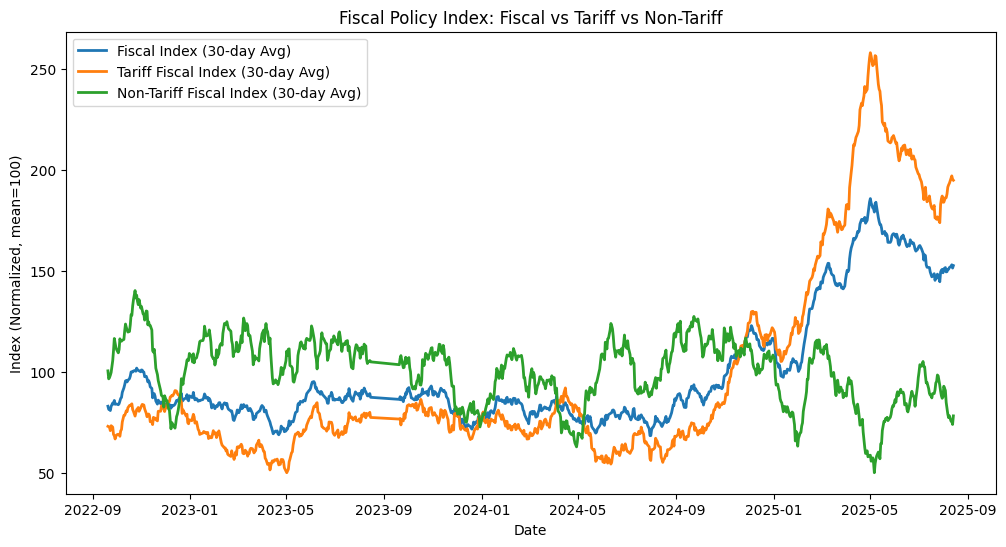

In [31]:
# EXPERIMENT CODE

import pandas as pd
import matplotlib.pyplot as plt

# Plot with 7-day rolling average 
plt.figure(figsize=(12,6))

plt.plot(
    wsj_fpi["date"], wsj_fpi["fiscal_policy_index"].rolling(30).mean(),
    label="Fiscal Index (30-day Avg)", linewidth=2
)
plt.plot(
    wsj_fpi["date"], wsj_fpi["tariff_fiscal_index"].rolling(30).mean(),
    label="Tariff Fiscal Index (30-day Avg)", linewidth=2
)
plt.plot(
    wsj_fpi["date"], wsj_fpi["non_tariff_fiscal_index"].rolling(30).mean(),
    label="Non-Tariff Fiscal Index (30-day Avg)", linewidth=2
)

plt.title("Fiscal Policy Index: Fiscal vs Tariff vs Non-Tariff")
plt.xlabel("Date")
plt.ylabel("Index (Normalized, mean=100)")
plt.legend()
plt.show()
